## Building the Ship

In [266]:
import random

# d = int(input("Grid size: "))
d = 40

grid = [[0 for _ in range(d+2)] for _ in range(d+2)]
    
# Set the first and last rows to 1s
for j in range(d+2):
    grid[0][j] = 2  # First row
    grid[d+1][j] = 2  # Last row

# Set the first and last columns to 1s
for i in range(d+2):
    grid[i][0] = 2 # First column
    grid[i][d+1] = 2 # Last column
    
for r in grid:
    for c in r:
        print(c, end=" ")
    print()

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 
2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [267]:
def checkNeighbors(grid, r, c, a):
    return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

In [268]:

x = random.randint(1, d)
y = random.randint(1, d)


fringe = []
fringe.append((x,y))

deadEnds = []

while len(fringe) > 0:
    curr = random.choice(fringe)
    fringe.remove(curr)
    r, c = curr[0], curr[1]
    if checkNeighbors(grid, r, c, 1) > 1:
        continue
    grid[r][c] = 1
    up = (r-1, c) 
    down = (r+1, c) 
    left = (r, c-1) 
    right = (r, c+1)
    deadEnd = True
    for elt in [up, down, left, right]:
        if grid[elt[0]][elt[1]] == 0:
            numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
            if numOpenNeighbors == 1:
                deadEnd = False
                fringe.append(elt)
    if deadEnd:
        deadEnds.append(curr)
        

count = 0   
for row in grid:
    count += row.count(1)

print(f"Percent of cells opened: {100*count/(d*d)}")

Percent of cells opened: 60.625


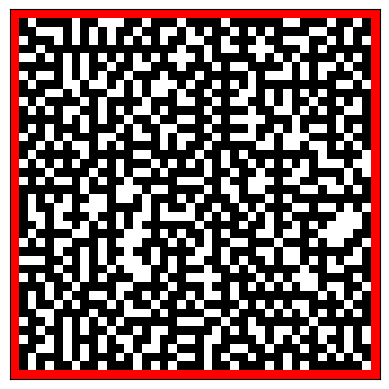

In [269]:
import matplotlib.pyplot as plt
import numpy as np

color_map = {
    0: 'white',
    1: 'black',
    2: 'red'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(grid)):
    for j in range(len(grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(grid[0]))
ax.set_ylim(0, len(grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

black = open cells, red = wall

In [270]:
for elt in deadEnds:
    if grid[elt[0]][elt[1]] == 2:
        deadEnds.remove(elt)
        continue
    numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
    if numOpenNeighbors > 1:
        deadEnds.remove(elt)

newList = random.sample(deadEnds, len(deadEnds) // 2)
for elt in newList:
    r = elt[0]
    c = elt[1]
    up = (r-1, c) 
    down = (r+1, c) 
    left = (r, c-1) 
    right = (r, c+1)
    neighbors = [up,down,left,right]
    for pt in neighbors:
        if grid[pt[0]][pt[1]] == 1 or grid[pt[0]][pt[1]] == 2:
            neighbors.remove(pt)
#     print(neighbors)
    curr = random.choice(neighbors)
    while grid[curr[0]][curr[1]] == 2:
        curr = random.choice(neighbors)
    grid[curr[0]][curr[1]] = 1

count = 0   
for row in grid:
    count += row.count(1)

print(f"Percent of cells opened: {100*count/(d*d)}")

Percent of cells opened: 65.125


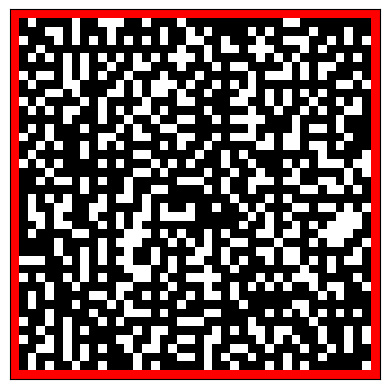

In [271]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(grid)):
    for j in range(len(grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(grid[0]))
ax.set_ylim(0, len(grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

## Coding the Fire


In [272]:
def setFire(grid, pt, q):
    if grid[pt[0]][pt[1]] == 3:
        return
    k = checkNeighbors(grid, pt[0], pt[1], 3)
    prob = 1 - (1-q)**k
    x = random.random()
    if x <= prob:
        grid[pt[0]][pt[1]] = 3
    return

In [273]:
def spreadFire(grid, fireLocs, q, df=None, i=None, timestep=None):
    fireLocsNew = []
    for curr in fireLocs:
        if grid[curr[0]][curr[1]] == 2:
            fireLocs.remove(curr)
            continue
        setFire(grid, curr, q)
        if grid[curr[0]][curr[1]] == 3:
            fireLocs.remove(curr)
            if df is not None and i is not None and timestep is not None:
                df.loc[curr][i] = timestep
            neighbors = [(curr[0]-1,curr[1]), (curr[0]+1,curr[1]), (curr[0], curr[1]-1), (curr[0], curr[1]+1)]
            for elt in neighbors:
                if grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4:
                    fireLocsNew.append(elt)
    fireLocs.extend(fireLocsNew)
    return fireLocs

In [274]:
def reset_grid(grid):
    for i in range(len(grid)):  # Iterate through rows
            for j in range(len(grid[i])):  # Iterate through columns
                if (grid[i][j] in range(3,7)):
                    grid[i][j] = 1
#     grid[fireLoc[0]][fireLoc[1]] = 3

## Location Initializations

In [275]:
def location_initialization(grid, botLoc=None, butLoc=None, fireLoc=None):
    botLoc = (random.randint(1, d), random.randint(1, d))
    while grid[botLoc[0]][botLoc[1]] == 0:
        botLoc = (random.randint(1, d), random.randint(1, d))

    butLoc = (random.randint(1, d), random.randint(1, d))
    while grid[butLoc[0]][butLoc[1]] == 0:
        butLoc = (random.randint(1, d), random.randint(1, d))

    fireLoc = (random.randint(1, d), random.randint(1, d))
    while grid[fireLoc[0]][fireLoc[1]] == 0:
        fireLoc = (random.randint(1, d), random.randint(1, d))

    notDistinct = (botLoc == butLoc) or (botLoc == fireLoc) or (butLoc == fireLoc)
    #print(distinct)

    while notDistinct:
        while grid[botLoc[0]][botLoc[1]] == 0:
            botLoc = (random.randint(1, d), random.randint(1, d))
        while grid[butLoc[0]][butLoc[1]] == 0:
            butLoc = (random.randint(1, d), random.randint(1, d))
        while grid[fireLoc[0]][fireLoc[1]] == 0:
            fireLoc = (random.randint(1, d), random.randint(1, d))
    
    return botLoc,butLoc,fireLoc

botLoc,butLoc,fireLoc = location_initialization(grid)
print(f"Bot Location: {botLoc}")
print(f"Button Location: {butLoc}")
print(f"Fire Location: {fireLoc}")

Bot Location: (39, 3)
Button Location: (15, 27)
Fire Location: (5, 23)


## Shortest Path (Bot 1)

In [276]:
import copy

bot1Grid = copy.deepcopy(grid)
bot1Grid[fireLoc[0]][fireLoc[1]] = 3

def shortestBot1(grid, botLoc, fireLocs, butLoc):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
#             print("Success")
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)

    path = []
    curr = butLoc
    while curr is not None:
        path.append(curr)
        curr = prev1[curr]

    # Return the path from start to finish
#     path = path[::-1]  # Reverse the path to go from start to finish
    return path[::-1]


## Game Loop (Bot 1)

In [277]:
def gameLoop1(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    grid[r][c] = 3
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path = shortestBot1(bot1Grid, botLoc, fireLocs, butLoc)
    for i in path[1:]:
        fireLocs = spreadFire(bot1Grid, fireLocs, q=q)
        if bot1Grid[i[0]][i[1]] == 3:
            if trackTime: print(f"Bot1 failed in {t} timesteps.")
            success = False
            break
        t = t + 1
        bot1Grid[i[0]][i[1]] = 4
    l = len(path)
    bot1Grid[butLoc[0]][butLoc[1]] = 5
    bot1Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_1 = gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_1: print("Success!")

Bot1 failed in 38 timesteps.


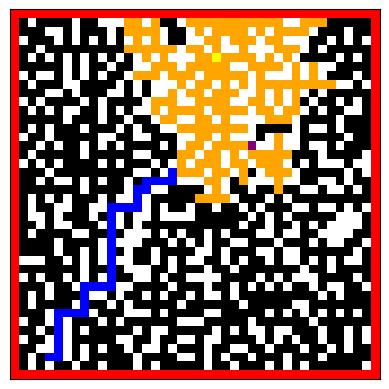

In [278]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot1Grid)):
    for j in range(len(bot1Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot1Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot1Grid[0]))
ax.set_ylim(0, len(bot1Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

The yellow dot represents the source of the fire. The pink dot represents the button.

In [279]:
reset_grid(bot1Grid)

## Shortest Path (Bot 2)

In [280]:
def shortestBot2(grid, botLoc, fireLocs, butLoc, i, path):
    currentFires = set([])
    currentFires.add(fireLoc)
    for row in range(len(grid)):
        for col in range(len(grid[row])):
            if grid[row][col] == 3:
                currentFires.add((row, col))
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and elt not in currentFires:
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 2)

In [281]:
bot2Grid = copy.deepcopy(grid)
bot2Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop2(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot2 = []
    pathBot2.append(botLoc)
    pathBot2 = shortestBot2(bot2Grid, botLoc, fireLocs, butLoc, 0, pathBot2)
    i = 1
    while i < len(pathBot2):
        fireLocs = spreadFire(bot2Grid, fireLocs, q=q)
        if bot2Grid[pathBot2[i][0]][pathBot2[i][1]] == 3:
            if trackTime: 
                print(f"Bot2 failed in {t} timesteps.")
            success= False
            break
        bot2Grid[pathBot2[i][0]][pathBot2[i][1]] = 4
        pathBot2 = shortestBot2(bot2Grid, pathBot2[i], fireLocs, butLoc, i, pathBot2)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot2Grid[butLoc[0]][butLoc[1]] = 5
    bot2Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
success_2 = gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_2: print(f"Success!")

Bot2 failed in 77 timesteps.


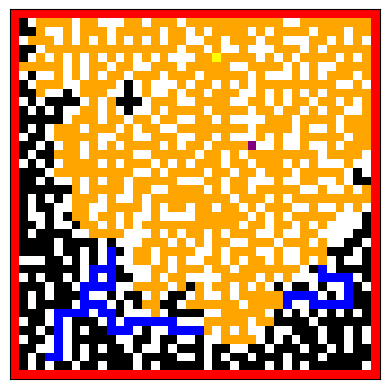

In [282]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot2Grid)):
    for j in range(len(bot2Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot2Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot2Grid[0]))
ax.set_ylim(0, len(bot2Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

In [283]:
reset_grid(bot2Grid)

## Shortest Path (Bot 3)

In [284]:
def shortestBot3(grid, botLoc, fireLocs, butLoc, i, path):
    fringe1 = []
    fringe1.append(botLoc)

    closed_set = {}
    prev1 = {}
    prev1[botLoc] = None
    success = False

    while len(fringe1) > 0:
        curr1 = fringe1.pop(0)
        if curr1 == butLoc:
            #print(curr1)
            success = True
            break

        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if (grid[elt[0]][elt[1]] == 1 or grid[elt[0]][elt[1]] == 4) and elt not in closed_set and (elt not in fireLocs or elt == butLoc):
                    fringe1.append(elt)
                    prev1[elt] = curr1
    #print(prev1)
    if not success: 
        return path

    path2 = []
    curr = butLoc
#     print(prev1)
    while curr is not None:
        path2.append(curr)
        curr = prev1[curr]
    path2 = path2[::-1]
    if path2 != path[i:]:
        path[i:] = path2

    # Return the path from start to finish
    return path  # Reverse the path to go from start to finish

## Game Loop (Bot 3)

In [291]:
bot3Grid = copy.deepcopy(grid)
bot3Grid[fireLoc[0]][fireLoc[1]] = 3

def gameLoop3(grid, botLoc, fireLoc, butLoc, trackTime, q):
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    pathBot3 = []
    pathBot3.append(botLoc)
    pathBot3 = shortestBot3(bot3Grid, botLoc, fireLocs, butLoc, 0, pathBot3)
    i = 1
    while i < len(pathBot3):
        fireLocs = spreadFire(bot3Grid, fireLocs, q=q)
        if bot3Grid[pathBot3[i][0]][pathBot3[i][1]] == 3:
            if trackTime: 
                print(f"Bot3 failed in {t} timesteps.")
            success= False
            break
        bot3Grid[pathBot3[i][0]][pathBot3[i][1]] = 4
        pathBot3 = shortestBot3(bot3Grid, pathBot3[i], fireLocs, butLoc, i, pathBot3)
        t = t + 1
        i = i + 1
#     l = len(path)
    bot3Grid[butLoc[0]][butLoc[1]] = 5
    bot3Grid[fireLoc[0]][fireLoc[1]] = 6
    return success
print(gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, 0.5))

False


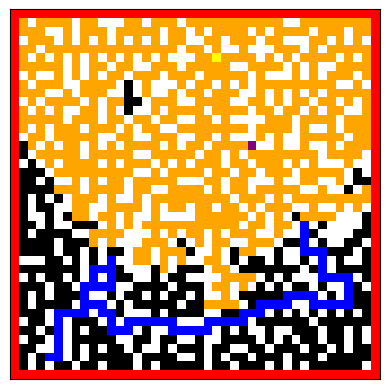

In [292]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot3Grid)):
    for j in range(len(bot3Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot3Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot3Grid[0]))
ax.set_ylim(0, len(bot3Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

In [290]:
reset_grid(bot3Grid)

## Bot 4 Logic
The expression that represents the probability of a given cell being set on fire is:
$$
1-(1-q)^K
$$
where
$q = \text{ship flammability,}$
$K = \text{number of on-fire neighbors.}$

Our approach for Bot 4 will be an implementation of Dijkstra's Shortest-Path Algorithm in which our cost function will take in a given cell's probability of being set on fire several steps in advance. There are a few ways to perform this:
1. Markov Chain Monte Carlo Method: Before starting the algorithm, simulate the fire spreading throughout the grid many times. Create a dataframe that records each open cell and which timestep it was set on fire, with cells as rows and simulations as columns. We will be able to estimate the likelihood of a given cell being on fire by a given timestep by taking the rate of being on fire out of all simulations. This will give an estimate for the true distribution of probabilities for each cell. Then, when running Dijkstra's, when considering a cell for exploration, we take into account its calculated probability.
2. For each iteration of Dijkstra's, given a cell being considered, mathematically calculate its probability that it will be set on fire by a certain timestep. This is possible but would be more expensive than simulation.

We will choose option 1 with cost function $$C(node)=c*p(node)*d$$ 
where 
$$c=\text{some constant},$$
$$p(node)=\text{probability of a node being on fire by the time the bot reaches it},$$
$$d=\text{Manhattan distance from node to button.}$$

Note that using the Manhattan distance is a relaxation of the problem, as it assumes that every cell between the bot and the button is open.

Also note that the constant $c$ allows us to quantify how risk-averse we want to be. A higher $c$ will punish higher probabilities and higher estimated distances. For now we will set $c=1$.

## Bot 4 Data Collection

In [228]:
def simulateFire(grid, fireLoc, df, numSims, q):
    r,c = fireLoc[0], fireLoc[1]
    for i in range(numSims):
        grid[r][c] = 3
        fireLocs = []
        fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
        t = 0
        while len(fireLocs) > 0:
            fireLocs = spreadFire(grid, fireLocs, q, df, i, t)
            t = t + 1
        reset_grid(grid)
    return df

In [229]:
def p(pt, df, t):
    return ((df.loc[pt] <= t).sum() / len(df.columns))

In [230]:
def d_manhattan(pt, butLoc):
    return abs(butLoc[0]-pt[0]) + abs(butLoc[1]-pt[1])

In [231]:
def C(pt, df, t, butLoc):
    return 2 * p(pt, df, t) * d_manhattan(pt, butLoc)

In [232]:
import itertools
import pandas as pd

bot4Grid = copy.deepcopy(grid)
def simulateBot4(grid, fireLoc, q):
    numSims = 50
    cells = list(itertools.product(range(1, 41), repeat=2))
    df = pd.DataFrame(0, index=pd.MultiIndex.from_tuples(cells, names=["Row", "Col"]),
                      columns=[f'Sim_{i+1}' for i in range(numSims)])
    df = simulateFire(grid, fireLoc, df, numSims, q)
    return df

df = simulateBot4(bot4Grid, fireLoc, 0.5)
print(df.head())

         Sim_1  Sim_2  Sim_3  Sim_4  Sim_5  Sim_6  Sim_7  Sim_8  Sim_9  \
Row Col                                                                  
1   1      100    113    123     94    113    124    110     94     97   
    2       98    108    120     95    108    120    106     91     95   
    3       96    107    121     91    106    119    104     90     93   
    4       95    104    118     90    100    115    103     88     88   
    5       91    102    115     89     99    113    102     86     87   

         Sim_10  ...  Sim_41  Sim_42  Sim_43  Sim_44  Sim_45  Sim_46  Sim_47  \
Row Col          ...                                                           
1   1       105  ...     108     117     102     105      97      95     112   
    2       104  ...     107     113     101     105      96      94     110   
    3       103  ...     105     116      99     102      98      91     107   
    4        95  ...     104     117      91      99      94      84     105   
 

In [233]:
# Test it out
sampleLocation = (15,25)
print(f"Estimated cost of going to {sampleLocation} by 150 timesteps: {C(sampleLocation, df, 150, butLoc)}")

Estimated cost of going to (15, 25) by 150 timesteps: 62.0


## Shortest Path (Bot 4)

In [234]:
from queue import PriorityQueue as pq

def shortestBot4(grid, botLoc, butLoc, df):
    fringe4 = pq()
    fringe4.put((0.0, botLoc))

    dist = {}
    dist[botLoc] = 0

    prev4 = {}
    prev4[botLoc] = None
    
    time = {}
    time[botLoc] = 0

#     t = 1

    while fringe4.qsize() > 0:
        curr = fringe4.get()
        curr1 = curr[1]
        priority = curr[0]
        if curr1 == butLoc:
#             print("Success")
            break
        t = time[curr1]
        r1, c1 = curr1[0], curr1[1]
        neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
        for elt in neighbors1:
            if (elt[0] < 1 or elt[0] > 40) or (elt[1] < 1 or elt[1] > 40):
                continue
            elt_cost = C(elt, df, t+1, butLoc)
            if (bot4Grid[elt[0]][elt[1]] == 1 and (elt == butLoc or elt not in dist or elt_cost < dist[elt])):
                fringe4.put((elt_cost, elt))
                dist[elt] = elt_cost
                prev4[elt] = curr1
                time[elt] = t + 1

#         t = t + 1

    path4 = []
    curr = butLoc
    while curr is not None:
        path4.append(curr)
        curr = prev4[curr]

    # Return the path from start to finish
    return path4[::-1]

## Game Loop (Bot 4)

In [235]:
def gameLoop4(grid, botLoc, fireLoc, butLoc, trackTime, q):
    df = simulateBot4(grid, fireLoc, q=q)
    t = 1
    fireLocs = []
    r,c = fireLoc[0], fireLoc[1]
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    success = True
    path4 = []
    path4 = shortestBot4(bot4Grid, botLoc, butLoc, df)
    grid[r][c] = 3
    for i in path4[1:]:
        if i == path4[-1]:
            break
        fireLocs = spreadFire(bot4Grid, fireLocs, q=q)
        if bot4Grid[i[0]][i[1]] == 3:
            if trackTime: 
                print(f"Bot4 failed in {t} timesteps.")
            success= False
            break
        t = t + 1
        bot4Grid[i[0]][i[1]] = 4
    # l = len(path4)
    bot4Grid[butLoc[0]][butLoc[1]] = 5
    bot4Grid[fireLoc[0]][fireLoc[1]] = 6
    return success


success_4 = gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, True, 0.5)
if success_4: print("Success!")

Bot4 failed in 85 timesteps.


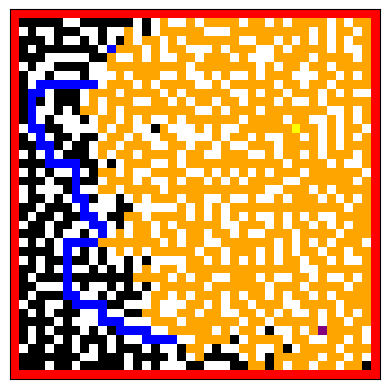

In [236]:
color_map = {
    0: 'white',
    1: 'black',
    2: 'red',
    3: 'orange',
    4: 'blue',
    5: 'purple',
    6: 'yellow'
}

# Create a figure and axis
fig, ax = plt.subplots()

# Create a grid where each cell is colored according to the value in the array
for i in range(len(bot4Grid)):
    for j in range(len(bot4Grid[i])):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[bot4Grid[i][j]]))

# Set grid limits and turn off axis
ax.set_xlim(0, len(bot4Grid[0]))
ax.set_ylim(0, len(bot4Grid))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.gca().invert_yaxis()  # Invert y-axis to make the grid origin (0,0) at the top-left corner
plt.show()

In [237]:
reset_grid(bot4Grid)

## Data Analysis

In [238]:
def does_path_exist(grid, fireLoc, butLoc, q):
    r,c = fireLoc[0], fireLoc[1]
    grid[fireLoc[0]][fireLoc[1]] = 3
    fireLocs = []
    fireLocs.extend(((r-1, c), (r+1, c), (r,c-1), (r,c+1)))
    while grid[butLoc[0]][butLoc[1]] != 3:
        fireLocs = spreadFire(grid, fireLocs, q)
    
    fringe = []
    fringe.append(botLoc)
    closed_set = {}
    
    while len(fringe) > 0:
        curr1 = fringe.pop(0)
        if curr1 == butLoc:
            reset_grid(grid)
            return True
            
        if curr1 not in closed_set:
            closed_set.update({curr1: 1})
            r1, c1 = curr1[0], curr1[1]
            neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
            for elt in neighbors1:
                if bot1Grid[elt[0]][elt[1]] == 1 and elt not in closed_set:
                    fringe.append(elt)
                    
    reset_grid(grid)
    return False
# botLoc,butLoc,fireLoc = location_initialization(grid)
# print(does_path_exist(grid, fireLoc, butLoc, 0.5))

In [239]:
q_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
success_df = pd.DataFrame(0, index=q_list, columns=['Bot1', 'Bot2', 'Bot3', 'Bot4'])
for q in q_list:
    success_rates = [0.0,0.0,0.0,0.0]
    counts = [0,0,0,0]
    for i in range(10):
        botLoc,butLoc,fireLoc = location_initialization(grid)
        while not does_path_exist(grid, fireLoc, butLoc, q):
            botLoc,butLoc,fireLoc = location_initialization(grid)
        if gameLoop1(bot1Grid, botLoc, fireLoc, butLoc, False, q):
            counts[0] += 1
        reset_grid(bot1Grid)
        if gameLoop2(bot2Grid, botLoc, fireLoc, butLoc, False, q):
            counts[1] += 1
        reset_grid(bot2Grid)
        if gameLoop3(bot3Grid, botLoc, fireLoc, butLoc, False, q):
            counts[2] += 1
        reset_grid(bot3Grid)
        if gameLoop4(bot4Grid, botLoc, fireLoc, butLoc, False, q):
            counts[3] += 1
        reset_grid(bot4Grid)
#         print(f"loop{i}")
    for x in range(len(counts)):
        success_rates[x] = counts[x]/10
    success_df.loc[q] = success_rates
    print(success_df.loc[q])

Bot1    1
Bot2    1
Bot3    1
Bot4    1
Name: 0.1, dtype: int64
Bot1    0.9
Bot2    1.0
Bot3    1.0
Bot4    0.8
Name: 0.2, dtype: float64
Bot1    0.6
Bot2    1.0
Bot3    1.0
Bot4    0.7
Name: 0.3, dtype: float64
Bot1    0.7
Bot2    1.0
Bot3    1.0
Bot4    0.9
Name: 0.4, dtype: float64
Bot1    0.7
Bot2    1.0
Bot3    1.0
Bot4    0.7
Name: 0.5, dtype: float64
Bot1    0.5
Bot2    1.0
Bot3    1.0
Bot4    0.5
Name: 0.6, dtype: float64
Bot1    0.7
Bot2    1.0
Bot3    1.0
Bot4    0.9
Name: 0.7, dtype: float64
Bot1    0.7
Bot2    1.0
Bot3    1.0
Bot4    0.6
Name: 0.8, dtype: float64
Bot1    0.2
Bot2    1.0
Bot3    1.0
Bot4    0.2
Name: 0.9, dtype: float64
Bot1    0.8
Bot2    1.0
Bot3    1.0
Bot4    0.8
Name: 1.0, dtype: float64


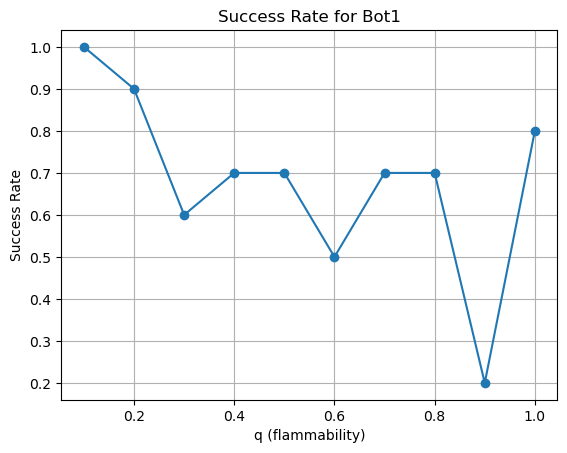

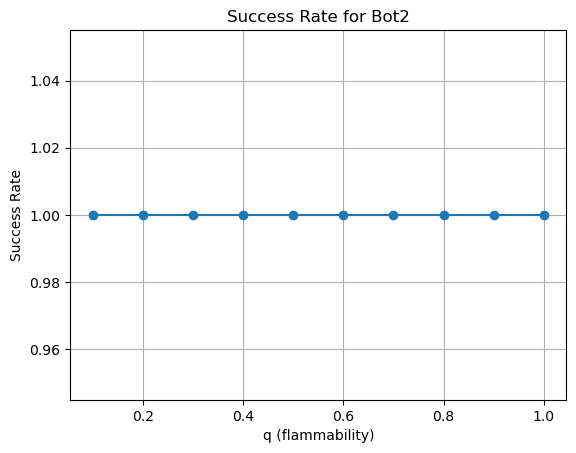

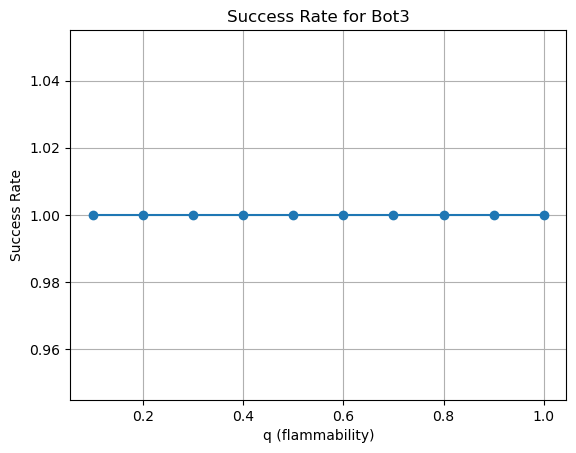

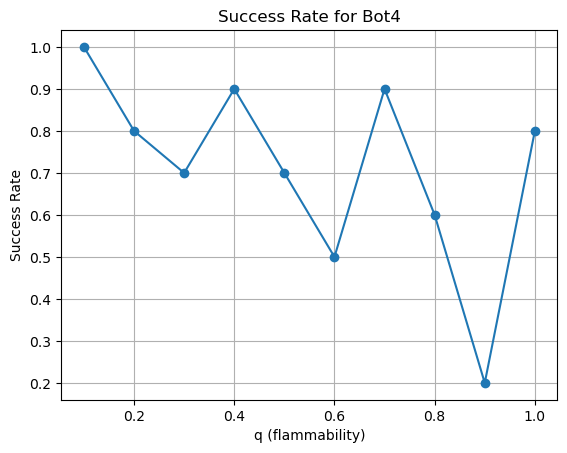

In [240]:

# Plotting for each bot
for bot in ['Bot1', 'Bot2', 'Bot3', 'Bot4']:
    plt.figure()  # Create a new figure for each bot
    plt.plot(q_list, success_df[bot], marker='o')
    
    # Add labels and title
    plt.title(f'Success Rate for {bot}')
    plt.xlabel('q (flammability)')
    plt.ylabel('Success Rate')
    
    # Show the grid for clarity
    plt.grid(True)
    
    # Show the plot
    plt.show()
